In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import joblib

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from utils import compute_descriptors, get_cv_splits, do_cv, plot_sem, fetch_best, train_and_pred_classification, train_and_pred_regression, normalize

# Introduction

This notebook will train a RandomForest classifier and regressor on the CACHE dataset. We will Search multiple parameters of the RF model to find the optimum combination. We will also experiment with both RDKit Physicochemical properties and Morgan Fingerprints.

We start by reading the data file

In [2]:
data_path = '../../Reference Data/20240430_MCHR1_splitted_RJ.csv'

# read the data file
challenge_data = pd.read_csv(data_path, index_col=0)

# These molecules cause problems when training the RF models using physchem descriptors as they throw a "value too large" error.
# The error is solved by either scaling the values or removing the molecules
challenge_data.drop([1645, 1646, 1647], axis=0, inplace=True)

challenge_data.head(4)

,aid,cid,acname,smiles,exp_type,source,acvalue_uM,class,ID,random_10f,DataSAIL_10f
Unnamed: 0,,,,,,,,,,,
0,262800,10128900,pKi,CN1CCN(CCCCN(C(=O)Nc2ccc(F)c(C(F)(F)F)c2)[C@@H...,displacement,patent,8.657577,1,ID00000,Fold_0,Fold_9
1,262800,10174940,pKi,N#Cc1cccc([C@]23CC[C@@H](N(CCCCN4CCCCC4)C(=O)N...,displacement,patent,8.795880,1,ID00001,Fold_8,Fold_9
2,262800,10195637,pKi,N#Cc1cccc([C@]23CC[C@@H](N(CCN4CCCCC4)C(=O)Nc4...,displacement,patent,8.387216,1,ID00002,Fold_8,Fold_9
3,262800,10238912,pKi,N#Cc1cccc([C@]23CC[C@@H](N(CCN4CC[C@@H](O)C4)C...,displacement,patent,7.657577,0,ID00003,Fold_8,Fold_9


# Featurization

The current data points are represented by string of SMILES language as shown in the `smiles` column above. We convert then to numerical values by using either the physichochemical properties of the molecules, or the circular fingerprints calculated by Morgan FPs.
   * For `physchem`, the 210 properties from RDKit are used
   * For `morgan_fp`, the default parameters of 2048 bits and `radius = 2` are specified. 

In [3]:
# add two new columns to the challenge dataframe, which will constitute the features from physchem and morgan_fp
for descriptor in ['physchem', 'morgan_fp']:   
    challenge_data[descriptor] = compute_descriptors(challenge_data['smiles'], method=descriptor)

calculating morgan_fp: 100%|██████████| 3021/3021 [00:00<00:00, 22599.57it/s]


# Cross-Validation -  Splitting

As a start, the data is provided such that each molecule is assigned a fold. It contains 10-folds for either random split or scaffold-based split. The last two folds, 8 and 9, will be reserved for the ensemble model, and therefore, they will be our test set. 
The remaining 8-folds will be used to perform 8-fold cross validation where one fold is used as an evaluation set, and the rest is used as a training set. We will be exploring multiple parameters for the Random Forest model, therefore, the combination with the best CV performance on average will be used for training the final model to be tested on the test set. 

In [4]:
num_folds=8
ensemble_cols = ['Fold_8', 'Fold_9']

ensemble_dfs = {}
cv_dfs = {}
splits_indices = {}
for split_col in ['random_10f', 'DataSAIL_10f']:
    ensemble_dfs[split_col] = challenge_data[challenge_data[split_col].isin(ensemble_cols)]
    cv_dfs[split_col] = challenge_data[~challenge_data[split_col].isin(ensemble_cols)]
    train_indices, eval_indices = get_cv_splits(cv_dfs[split_col],
                                                num_folds=num_folds,
                                                fold_col=split_col,
                                                )
    splits_indices[split_col] = (train_indices, eval_indices)

In [5]:
# Retrieve the features for each fold, either physchem or morgan_fp, and convert them to numpy arrays to be compatible as input for RF
def get_fold_features(df, descriptor, indices_list):
    return [np.array(df.loc[fold_indices][descriptor].to_list())
            for fold_indices in indices_list] 

fold_features = {}
for descriptor in ['physchem', 'morgan_fp']:
    for split_method, cv_df in cv_dfs.items():
        fold_features[f'train_{descriptor}_{split_method}'] = get_fold_features(cv_df, 
                                                                                descriptor,
                                                                                splits_indices[split_method][0])
        fold_features[f'eval_{descriptor}_{split_method}'] = get_fold_features(cv_df, 
                                                                               descriptor, 
                                                                               splits_indices[split_method][1])

## Parameters Grid
Before training the models, we specify the set of parameters that we want to explore. 
* here, we vary only the number of estimators (i.e., trees), the maximum number of features to be considered for each split, and the minimum number of samples at each leaf node. 
    * `n_jobs` controls the number of parallelization jobs between training the trees
    * `random_state` ensure the reproducibility of the results  
* we use the ParamsGrid sklearn function to perform the permutation of these parameters
With the current parameter, we will be training 28 models.

In [6]:
search_params = {'n_estimators': [250, 500, 1000],
                 'max_features': ['sqrt', 'log2', 0.3],
                 'min_samples_split': [2, 4, 6],
                 'n_jobs': [6],
                 'random_state': [1234]}
params_grid = list(ParameterGrid(search_params))
grid_df = pd.DataFrame(params_grid)
grid_df

,max_features,min_samples_split,n_estimators,n_jobs,random_state
0,sqrt,2,250,6,1234
1,sqrt,2,500,6,1234
2,sqrt,2,1000,6,1234
3,sqrt,4,250,6,1234
4,sqrt,4,500,6,1234
5,sqrt,4,1000,6,1234
6,sqrt,6,250,6,1234
7,sqrt,6,500,6,1234
8,sqrt,6,1000,6,1234
9,log2,2,250,6,1234


# Classification

To start with classification, we need to provide the corresponding label column that contains the classification of each molecule as either active or inactive. this column is named `class`. 
Afterwords, we start by training each one of the 28 models for each cross validation split.
We will be training the same parameter combinations using either `physchem` or `morgan_fp` descriptors using either the random split or the scaffold split, then plot the AUROC $\pm$ SE for each descriptor.

In [7]:
classification = True
label_col = 'class'

fold_targets_classification = {}
for split_method, cv_df in cv_dfs.items():
    fold_targets_classification[f'train_{split_method}'] = [cv_df.loc[fold_indices][label_col] for fold_indices in splits_indices[split_method][0]]
    fold_targets_classification[f'test_{split_method}'] = [cv_df.loc[fold_indices][label_col] for fold_indices in splits_indices[split_method][1]]
    
classification_performance = {}
for split_method in ['random_10f', 'DataSAIL_10f']:
    split_performance = {}
    for descriptor in ['physchem', 'morgan_fp']:
        train_features = fold_features[f'train_{descriptor}_{split_method}']
        train_targets = fold_targets_classification[f'train_{split_method}']
        eval_features = fold_features[f'eval_{descriptor}_{split_method}']
        eval_targets = fold_targets_classification[f'test_{split_method}']
        performance = {}
        for comb_idx, param_combination in tqdm(enumerate(params_grid), desc=f'training parameters grid - {split_method}_{descriptor}'):
            performance[comb_idx] = do_cv(train_features=train_features,
                                              train_targets=train_targets,
                                              test_features=eval_features,
                                              test_targets=eval_targets,
                                              classification=classification,
                                              model_params=param_combination)
        
        performance = pd.DataFrame(performance)
        split_performance[descriptor] = performance        
    classification_performance[split_method] = split_performance

training parameters grid - random_10f_physchem: 27it [04:16,  9.50s/it]
training parameters grid - random_10f_morgan_fp: 27it [07:24, 16.47s/it]
training parameters grid - DataSAIL_10f_physchem: 27it [03:55,  8.70s/it]
training parameters grid - DataSAIL_10f_morgan_fp: 27it [06:10, 13.73s/it]


## Random splitting
* We see that the best model using Morgan Fingerprints performed ~ 0.02 AUROC higher than the best model of the Physicochemical descriptors. Additionally, the SE bars for the `physchem` descriptors seems to be more spread than `morgan_fp` generally, which indicates lower confidence in the reported average performance. However, the best model from both descriptors overlap with respect to the standard error (SE), which suggests no significant difference between the performance of the two descriptors.
* The parameter combination for the `physchem` descriptors that performed the best on average is the combination at index 2, which is `n_estimators=1000, min_samples_split=2, and max_features=sqrt`.
* For `morgan_fp`, it is the combination at index 18, `n_estimators=250, min_samples_split=2, and max_features=0.3`.
* Since SE shows similar performance for almost all parameter combinations with both descriptors, there is not much to infer about the effect of the hyperparameters tuning with high confidence. 
    * The only significant observation we can see is between the best and worst performing combinations for `morgan_fp` as they do not overlap in SE. The combination corresponding to the worst performance is at index 17, which stands for `n_estimators=1000, min_samples_split=6, and max_features=log2`. This combination is characterised by the highest number of estimators (i.e., trees) in the specified combinations, but also the lowest number of features per split and the most restricted depth for each tree. This combination is also the exact opposite of the best combination for `morgan_fp`. 
        * Since random forests are robust against overfitting when increasing the number of trees, we can assume that the restricted depth and features are the main reason for such low performance. This is also can be understandable when considering that there are 2048 sparse features for each molecule, but only 11 features were examined at each split for the worst combination.    

max average physchem:  0.7068903218492726 ---> Corresponding index: 2
max average morgan_fp:  0.7271245148672161 ---> Corresponding index: 18


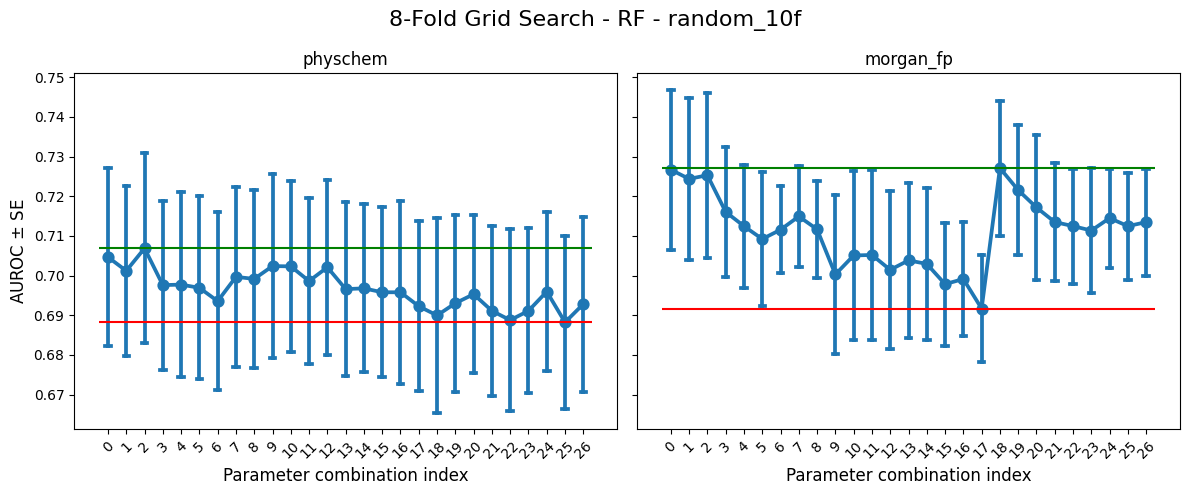

In [8]:
split_method = 'random_10f'
performance_df = classification_performance[split_method]
fetch_best(performance_df)
plot_sem(classification_performance[split_method], split_method, classification=classification)

## Scaffold split
* This time, it was the best model on average for physicochemical descriptor that performed ~ 0.01 AUROC better than the best model from Morgan FPs. But, again, the two descriptors performed similarly w.r.t SE. Additionally, the SE of both descriptors show widely spread SE ranges.  
* The best combinations on average for `physchem` ar at indices 1 followed by 4, and 6. These combinations have fixed parameters (`n_estimators=250 and max_features=0.3`) with varied  `min_samples_split` set to 2, 4, and 6.
* For `morgan_fp`, it is the combinations at indices 7, `n_estimators=500, min_samples_split=6, and max_features=sqrt`. This is a different behavior than what random split showed for the same descriptors.
* Again, SE shows similar performance for almost all parameter combinations with both descriptors, there is not much to infer about the effect of the hyperparameters tuning with high confidence. 
    * one observation is that using `max_features=log2` resulted in lower performance on average for both descriptors    

max average physchem:  0.5526450845415793 ---> Corresponding index: 1
max average morgan_fp:  0.545643153580579 ---> Corresponding index: 7


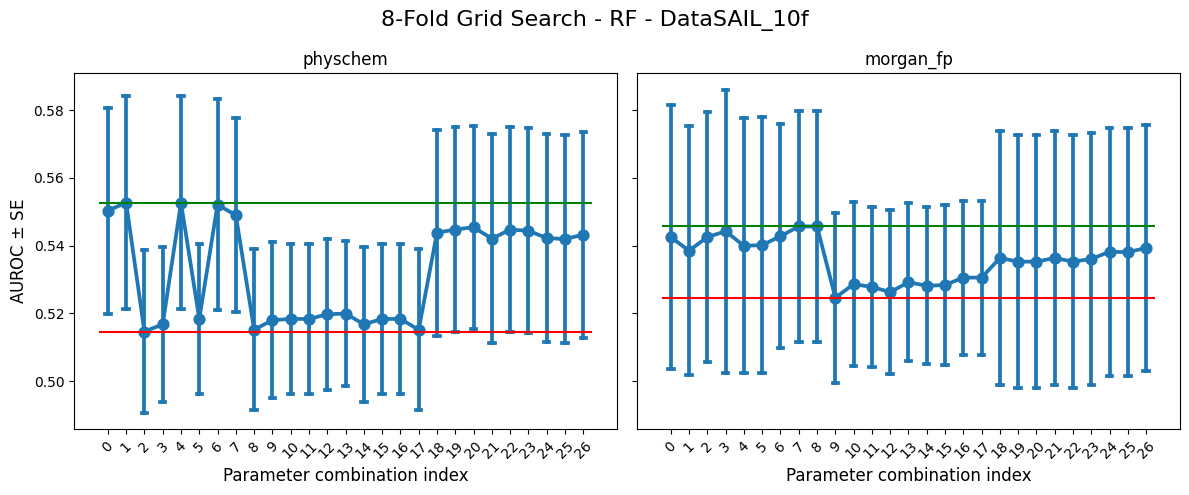

In [9]:
split_method = 'DataSAIL_10f'
performance_df = classification_performance[split_method]
fetch_best(performance_df)
plot_sem(classification_performance[split_method], split_method, classification=classification)

## Adding perspective

The above figures show nuanced differences between different descriptors performance. But when we scale the y-axis to 0 and 1, which is the limit of the AUROC. We can see clearly that all the mentioned differences are infinitesimal. 

* the green line crosses the best model on average while the red line crosses the worst model on average.

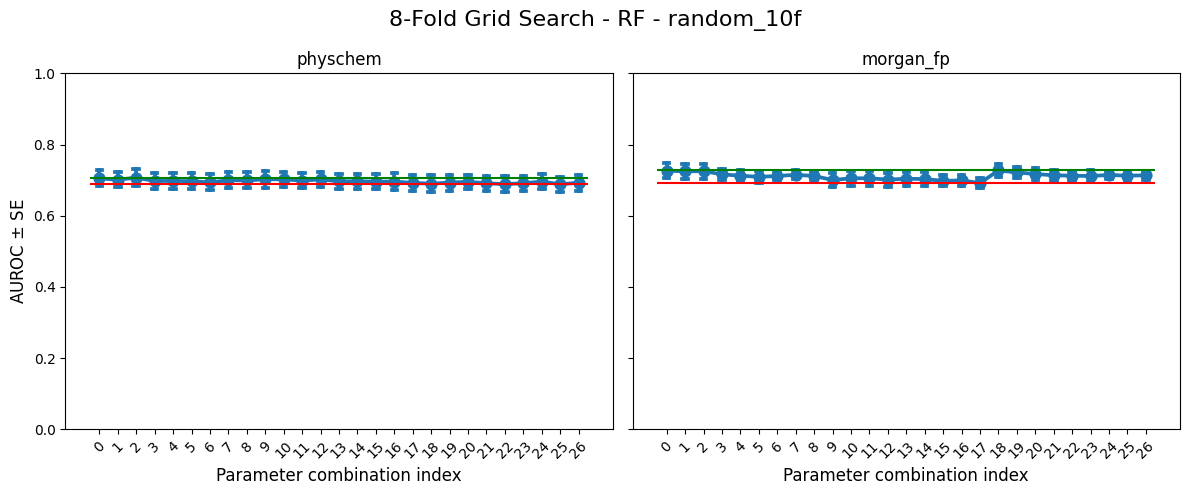

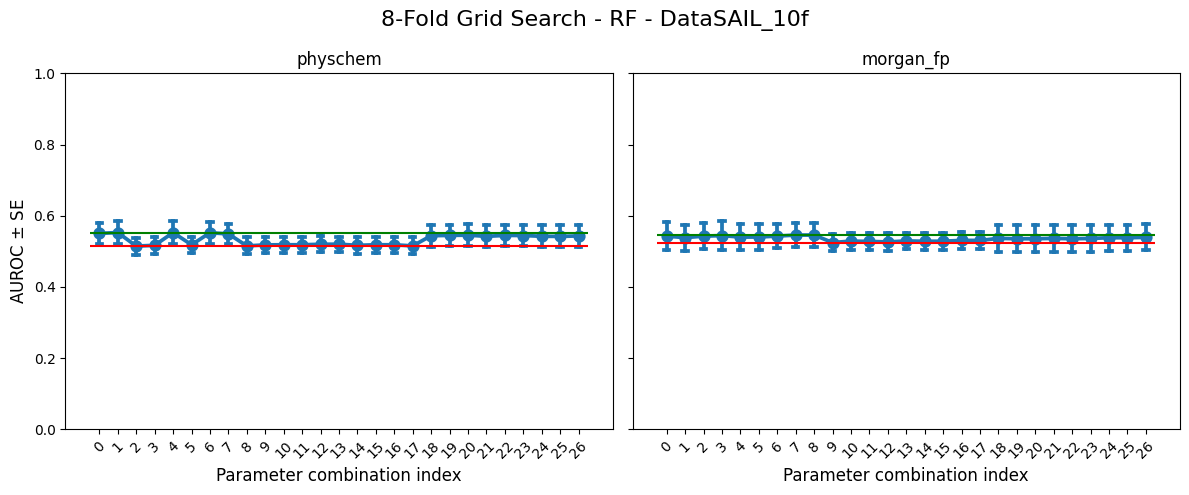

In [10]:
for split_method, split_performance in classification_performance.items():
    plot_sem(split_performance, split_method, classification=classification, ylim=(0,1))

# Regression

We will repeat the same analysis for regression by changing the column name of the target values. Here, it is the activ values in uM. Additionally, we will be normalizing the train target values to a mean of 0 and std of 1 to stabilize the predictions. The predicted values of the test features will be based on the normalized train set, therefore, the returned prediction will be transformed back to the original distribution of the train set by using the original mean and std values. Also, we evaluate the model using RMSE and MAE.

In [11]:
classification = False
regression_col = 'acvalue_uM'

fold_targets_regression = {}
for split_method, cv_df in cv_dfs.items():
    fold_targets_regression[f'train_{split_method}'] = [cv_df.loc[fold_indices][regression_col] for fold_indices in splits_indices[split_method][0]]
    fold_targets_regression[f'test_{split_method}'] = [cv_df.loc[fold_indices][regression_col] for fold_indices in splits_indices[split_method][1]]

regression_performance = {}
for split_method in ['random_10f', 'DataSAIL_10f']:
    split_performance = {}
    for descriptor in ['physchem', 'morgan_fp']:
        train_features = fold_features[f'train_{descriptor}_{split_method}']
        train_targets = fold_targets_regression[f'train_{split_method}']
        eval_features = fold_features[f'eval_{descriptor}_{split_method}']
        eval_targets = fold_targets_regression[f'test_{split_method}']
        performance = {}
        for comb_idx, param_combination in tqdm(enumerate(params_grid), desc=f'training parameters grid - {split_method}, {descriptor}'):
            reg_metrics = do_cv(train_features=train_features,
                                train_targets=train_targets,
                                test_features=eval_features,
                                test_targets=eval_targets,
                                classification=classification,
                                model_params=param_combination
                                )
            reg_metrics = np.array(reg_metrics)
            for key, val in {'rmse': reg_metrics[:,0], 'mae': reg_metrics[:,1]}.items():
                if key in performance.keys():
                    performance[key][comb_idx] = val
                else:
                    performance[key] = {comb_idx: val}
        
        performance = {reg_metric: pd.DataFrame(val) for reg_metric, val in performance.items()}
        split_performance[descriptor] = performance        
    regression_performance[split_method] = split_performance

training parameters grid - random_10f, physchem: 27it [04:15,  9.45s/it]
training parameters grid - random_10f, morgan_fp: 27it [06:40, 14.84s/it]
training parameters grid - DataSAIL_10f, physchem: 27it [04:11,  9.33s/it]
training parameters grid - DataSAIL_10f, morgan_fp: 27it [06:39, 14.80s/it]


## Random Splitting
* Again, all models perform similarly w.r.t SE across the single descriptor or between the two descriptors.
* `morgan_fp` seem to be performing better on average. for both RMSE and MAE.
* For RMSE, the best parameter's combination for `physchem` is the one at index 9, while for `morgan_fp`, it's index 20. 
* For MAE, it's indices 12, 15 for `physchem`and `morgan_fp`, respectively.

max average physchem - rmse:  1.4642581521224312 ---> Corresponding index: 9
max average morgan_fp - rmse:  1.4189165237610284 ---> Corresponding index: 20


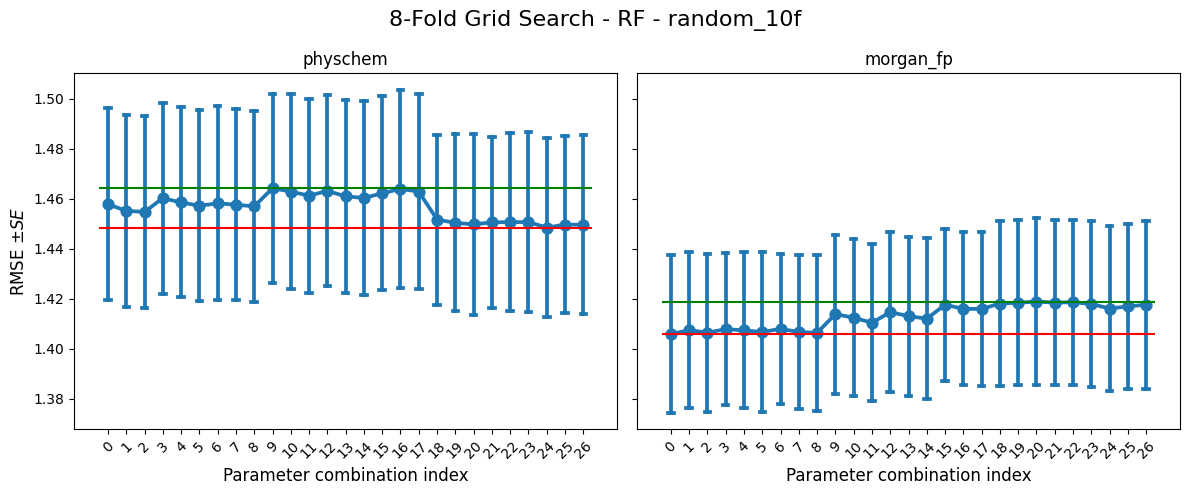

max average physchem - mae:  1.1583922547993866 ---> Corresponding index: 12
max average morgan_fp - mae:  1.1233550285001823 ---> Corresponding index: 15


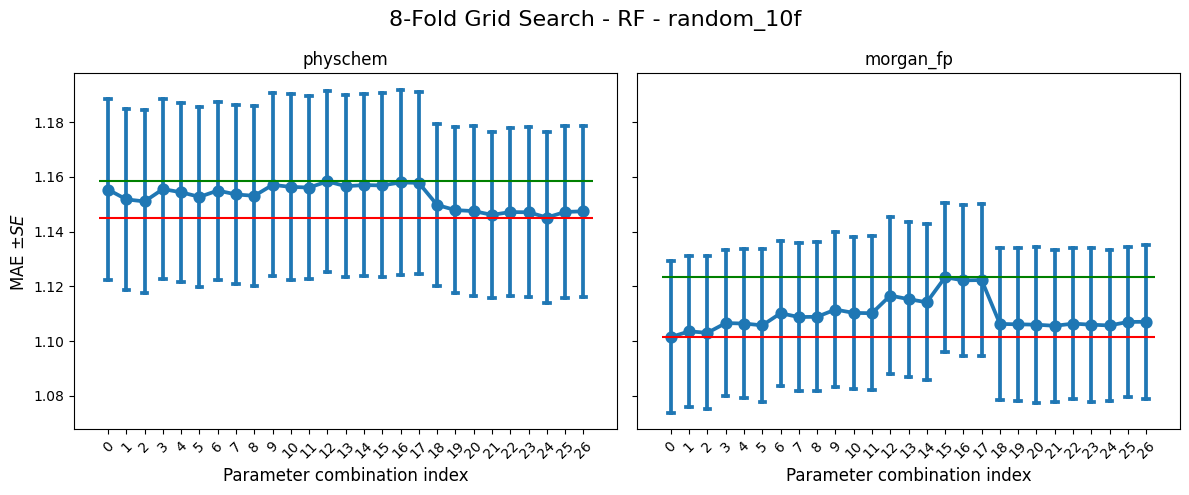

In [12]:
split_method = 'random_10f'
for reg_metric in ['rmse', 'mae']:
    plot_dict = {}
    for featurizer in split_performance.keys():
        performance_df = regression_performance[split_method][featurizer][reg_metric]
        plot_dict[featurizer] = performance_df
    fetch_best(plot_dict, reg_metric=reg_metric)
    plot_sem(plot_dict, split_method, classification=classification, reg_metric=reg_metric)

## Scaffold Splitting
* The same observation holds, all models perform similarly w.r.t SE across the single descriptor or between the two descriptors.
* This time, `physchem` seem to be performing better on average for both RMSE and MAE.
* For RMSE, the best parameter's combination for `physchem` is the one at index 18, while for `morgan_fp`, it's index 19. 
* For MAE, it's indices 24, 23 for `physchem` and `morgan_fp`, respectively.

max average physchem - rmse:  1.734255868151355 ---> Corresponding index: 18
max average morgan_fp - rmse:  1.78795284050492 ---> Corresponding index: 19


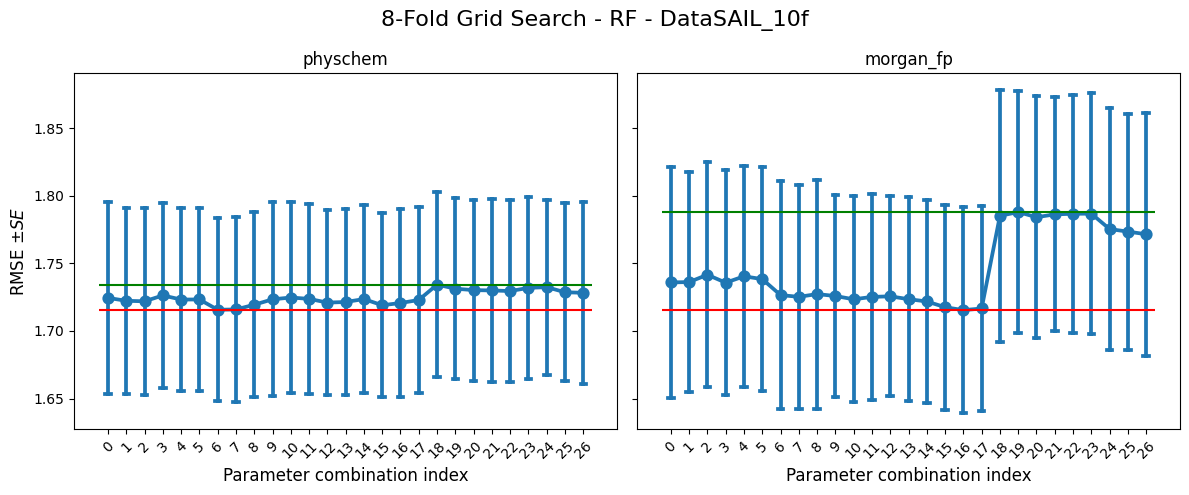

max average physchem - mae:  1.3970824546149603 ---> Corresponding index: 24
max average morgan_fp - mae:  1.4147234292585953 ---> Corresponding index: 23


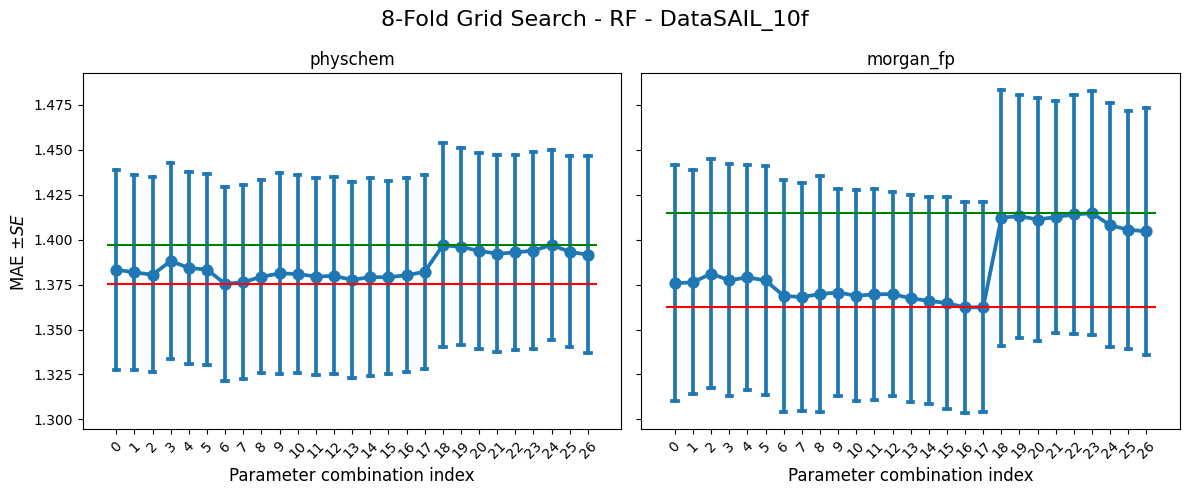

In [13]:
split_method = 'DataSAIL_10f'
for reg_metric in ['rmse', 'mae']:
    plot_dict = {}
    for featurizer in split_performance.keys():
        performance_df = regression_performance[split_method][featurizer][reg_metric]
        plot_dict[featurizer] = performance_df
    fetch_best(plot_dict, reg_metric=reg_metric)
    plot_sem(plot_dict, split_method, classification=classification, reg_metric=reg_metric)

## Adding perspective

The below figures show the same plots but with a new y-axis scal ranging from 0 (i.e., the lowest possible value) to slightly higher than the max SE value. This shows that the scale of performance differences is very minor.

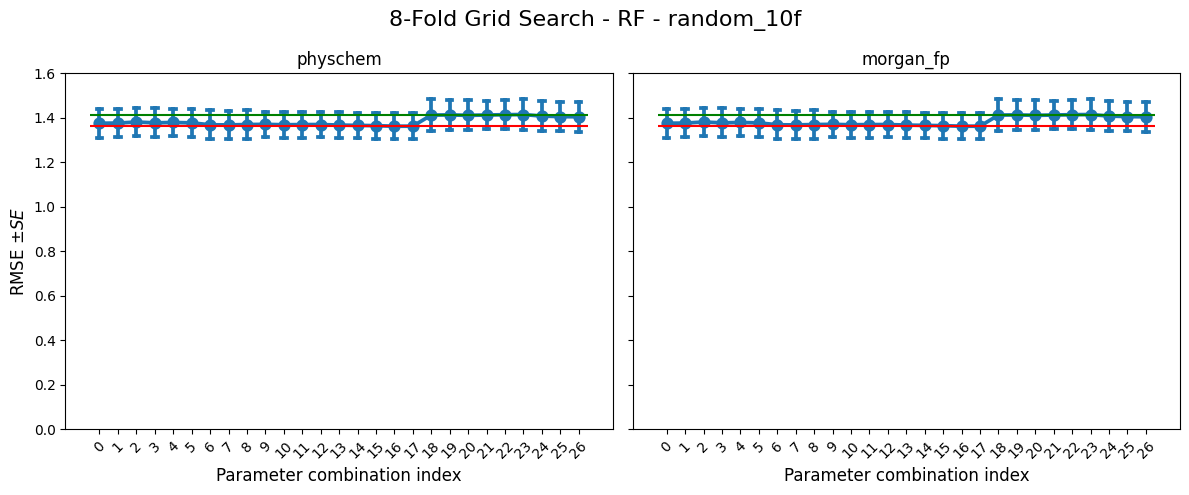

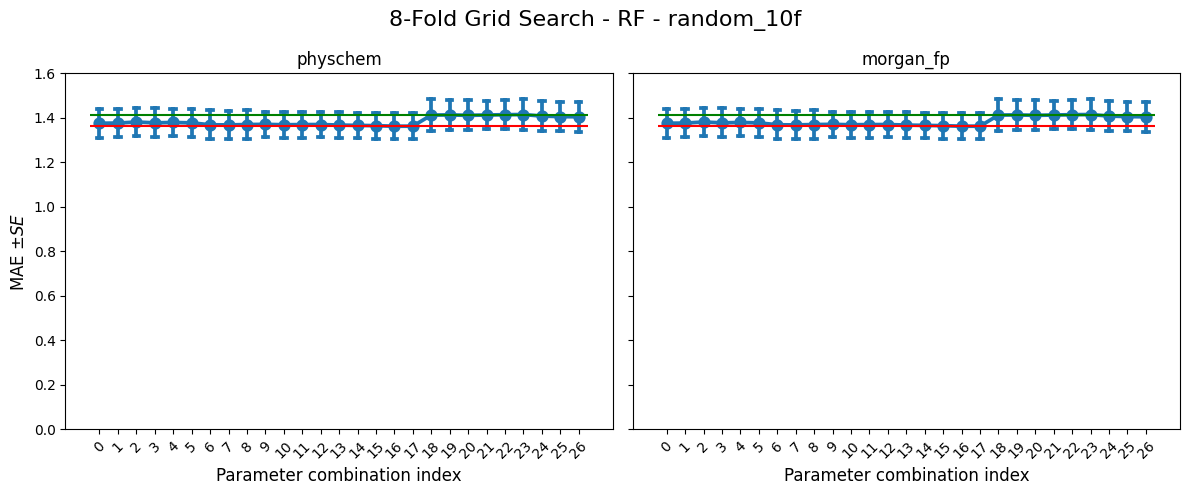

In [14]:
split_method = 'random_10f'
for reg_metric in ['rmse', 'mae']:
    plot_dict = {}
    for featurizer in split_performance.keys():
        plot_dict[featurizer] = performance_df
    plot_sem(plot_dict, split_method, classification=classification, reg_metric=reg_metric, ylim=(0,1.6))

max average physchem - rmse :  1.734255868151355
max average morgan_fp - rmse :  1.78795284050492


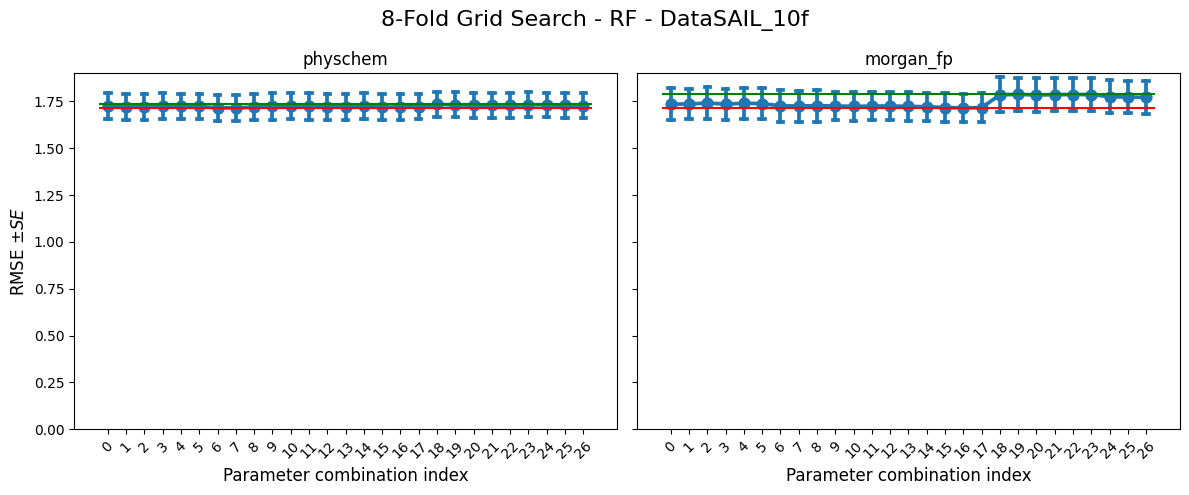

max average physchem - mae :  1.3970824546149603
max average morgan_fp - mae :  1.4147234292585953


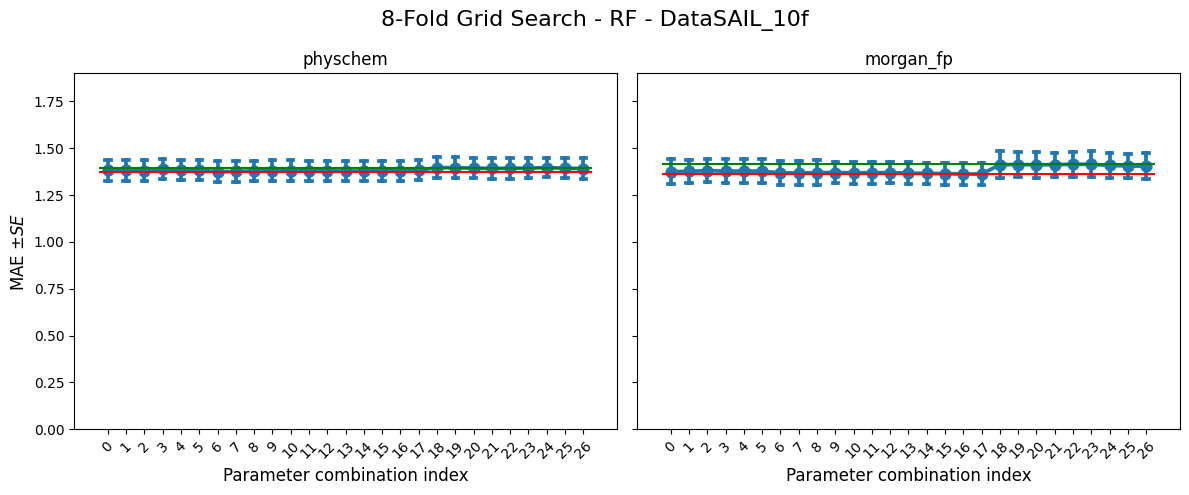

In [15]:
split_method = 'DataSAIL_10f'
for reg_metric in ['rmse', 'mae']:
    plot_dict = {}
    for featurizer in split_performance.keys():
        performance_df = regression_performance[split_method][featurizer][reg_metric]
        print(f'max average {featurizer} - {reg_metric} : ', max(performance_df.mean()))
        plot_dict[featurizer] = performance_df
    plot_sem(plot_dict, split_method, classification=classification, reg_metric=reg_metric, ylim=(0,1.9))

# Conclusion
We can see that there is almost no significant difference across or between any descriptor method for each split. We find `morgan_fp` to be performing slightly better tha `physchem` for both classification and regression for the random split, but `physchem` performs slightly better for the scaffold split for both classification and regression.

# Testing

Now, that we identified the best performing parameter combination on average for each split and each descriptor, we will train a final model on all the folds that were reserved for CV, then test this model on the ensemble folds. We will return a probability for the classification model, and a regression metric (i.e., RMSE and MAE) for the regression model. 
These predictions will be passed to the ensemble phase.
* we will train a scaffold-based model only as the random splitting models were carried out only to showcase the difference in performance ranges.

The best parameters for each model and descriptor are specified as shown above.

In [16]:
split_col = 'DataSAIL_10f'
best_params = {'classification_physchem': params_grid[1],
               'classification_morgan_fp': params_grid[7],
               'regression_physchem': params_grid[18],
               'regression_morgan_fp': params_grid[19]
               }
train_df = challenge_data[~challenge_data[split_col].isin(ensemble_cols)]
test_df = challenge_data[challenge_data[split_col].isin(ensemble_cols)]
test_ids = test_df['ID'].to_list()
models_pred = {}
for ml_objective, target_col in {'classification': 'class', 'regression': 'acvalue_uM'}.items():
    if ml_objective == 'classification':
        classification = True
    else:
        classification = False
    
    train_targets = train_df[target_col]
    test_targets = test_df[target_col]
    for descriptor in ['physchem', 'morgan_fp']:
        train_features = pd.DataFrame(train_df[descriptor].to_list())
        test_features = pd.DataFrame(test_df[descriptor].to_list()) 
        model_parms = best_params[f'{ml_objective}_{descriptor}']
        if descriptor not in models_pred:
            models_pred[descriptor] = {}
        if classification:
            model, probs, auroc = train_and_pred_classification(train_features, train_targets, test_features, test_targets, model_parms)
            models_pred[descriptor]['cls_prob'] = probs
            print(f'Performance on Ensemble folds - {descriptor} - AUROC: ', auroc)
        else:
            model, preds, rmse, mae = train_and_pred_regression(train_features, train_targets, test_features, test_targets, model_parms)
            models_pred[descriptor]['pIC50'] = preds
            print(f'Performance on Ensemble folds - {descriptor} - RMSE: ', rmse)
            print(f'Performance on Ensemble folds - {descriptor} - MAE: ', mae)

Performance on Ensemble folds - physchem - AUROC:  0.529126213592233
Performance on Ensemble folds - morgan_fp - AUROC:  0.4451261160169781
Performance on Ensemble folds - physchem - RMSE:  1.6760128260196576
Performance on Ensemble folds - physchem - MAE:  1.3386479108691807
Performance on Ensemble folds - morgan_fp - RMSE:  1.7802860455584573
Performance on Ensemble folds - morgan_fp - MAE:  1.4184205195033792


In [17]:
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

for descriptor in ['physchem', 'morgan_fp']:
    preds_dict = models_pred[descriptor]
    preds_dict['ID'] = test_ids
    pd.DataFrame(preds_dict).to_csv(os.path.join(output_dir, f'RF_{descriptor}_preds.csv'), index=False)

# Screening
The final goal is to screen the diversity-set of the Enamine database, which contains ~ 84M molecules. For the maximum benefit, the models to be used for evaluating the Enamine database will be trained on all the molecules in the challenge dataset. Here, there is no need for evaluation and testing as the model will be based on what we learned from the CV step, and is already assigned a contribution from the Ensemble step.   

In [19]:
output_dir = os.path.join(output_dir, 'models')
os.makedirs(output_dir, exist_ok=True)

for ml_objective, target_col in {'classification': 'class', 'regression': 'acvalue_uM'}.items():
    if ml_objective == 'classification':
        classification = True
    else:
        classification = False
    
    train_targets = challenge_data[target_col]
    for descriptor in ['physchem', 'morgan_fp']:
        train_features = pd.DataFrame(challenge_data[descriptor].to_list())
        model_parms = best_params[f'{ml_objective}_{descriptor}']
        if classification:
            model = RandomForestClassifier(**model_parms)
        else:
            model = RandomForestRegressor(**model_parms)
            train_targets, mean, std = normalize(train_targets)
            pd.DataFrame({'mean': [mean], 'std': [std]}).to_csv(os.path.join(output_dir, 'normalization_info.csv'), index=False)
        model.fit(train_features, train_targets)
        joblib.dump(model, os.path.join(output_dir, f"rf_{ml_objective}_{descriptor}.joblib"))